In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import mlflow
import mlflow.sklearn

In [6]:
df = pd.read_csv('../data/processed/churn_engineered.csv')
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

print(f"Features: {X.shape[1]}")
print(f"Samples: {len(X)}")

Features: 32
Samples: 7043


In [9]:
from sklearn.preprocessing import LabelEncoder

# Drop ID column if exists
X = df.drop(['customerID', 'Churn'], axis=1, errors='ignore')

# Automatically convert categorical to numeric (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Encode target
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"✅ Features after encoding: {X.shape[1]}")


✅ Train samples: 5634 | Test samples: 1409
✅ Features after encoding: 6573


In [11]:
print("\n🌲 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

print(f"Random Forest ROC-AUC: {rf_auc:.4f}")
print(classification_report(y_test, rf_pred))


🌲 Training Random Forest...
Random Forest ROC-AUC: 0.8398
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1035
           1       0.77      0.28      0.41       374

    accuracy                           0.79      1409
   macro avg       0.78      0.62      0.64      1409
weighted avg       0.78      0.79      0.75      1409



In [12]:
print("\n⚡ Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)
xgb_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_proba)

print(f"XGBoost ROC-AUC: {xgb_auc:.4f}")
print(classification_report(y_test, xgb_pred))


⚡ Training XGBoost...
XGBoost ROC-AUC: 0.8293
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [13]:
print("\n💡 Training LightGBM...")
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train_scaled, y_train)

lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_proba)

print(f"LightGBM ROC-AUC: {lgbm_auc:.4f}")
print(classification_report(y_test, lgbm_pred))


💡 Training LightGBM...
LightGBM ROC-AUC: 0.8269
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [14]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'ROC-AUC': [rf_auc, xgb_auc, lgbm_auc]
}).sort_values('ROC-AUC', ascending=False)

print("\n📊 Model Comparison:")
print(results)


📊 Model Comparison:
           Model   ROC-AUC
0  Random Forest  0.839775
1        XGBoost  0.829327
2       LightGBM  0.826914


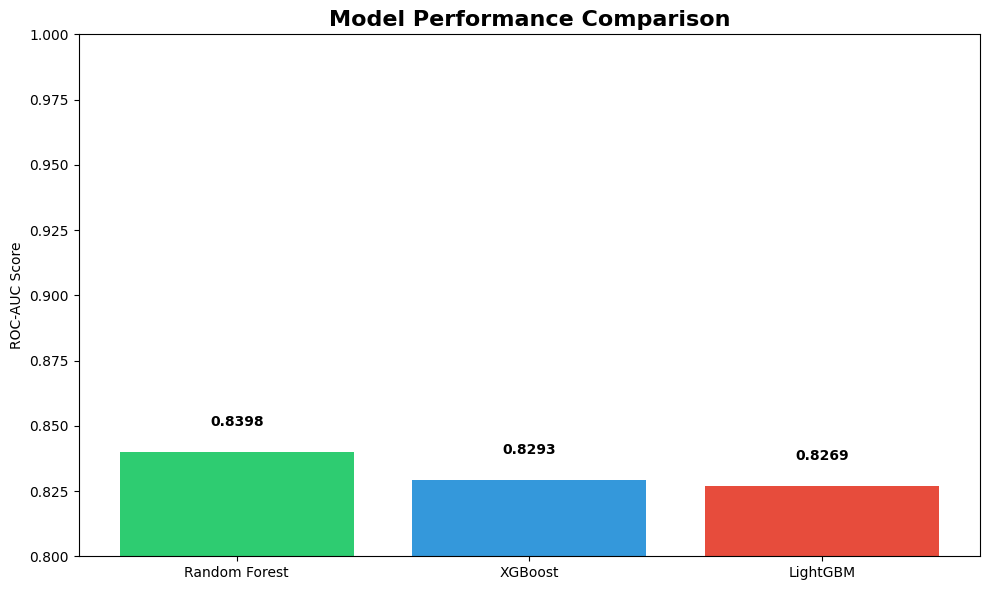

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['ROC-AUC'], color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('ROC-AUC Score')
plt.ylim(0.8, 1.0)
for i, v in enumerate(results['ROC-AUC']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
import joblib
best_model = xgb_model if xgb_auc == max(rf_auc, xgb_auc, lgbm_auc) else \
             (lgbm_model if lgbm_auc > rf_auc else rf_model)

joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Best model saved!")

✅ Best model saved!
